## Step 1:
Let the program know where to find your tools file.

In [1]:
import sys, os
sys.path.append(os.path.join(os.path.realpath(".."), "Tools"))

## Step 2:
Load up all of the necessary packages

In [2]:
from plastid import BAMGenomeArray,GTF2_TranscriptAssembler,Transcript
import numpy as np
import pandas as pd
from plastid.plotting.plots import *
import utilities as utils
import matplotlib.pyplot as plt
from matplotlib.pyplot import figure
from Bio import SeqIO
from Bio.Alphabet import generic_dna
from Bio.Seq import Seq
from scipy import stats
import math

%matplotlib inline

## Step 3:
define the paths to our reference genome and annotation files as well as the path to our list of autism spectrum disorder (ASD) genes

In [62]:
reference_path = "/home/keeganfl/Desktop/Work_Fall_2021/Protocol_test/genome/dmel/"
data_path = "/home/keeganfl/Desktop/measuring_binding_domains/data/"
figure_path = "/home/keeganfl/Desktop/measuring_binding_domains/Q20/Figures/"
table_path = "/home/keeganfl/Desktop/measuring_binding_domains/Q20/Tables/"

## Step 4: 
load the transcript and genome files so that we can find the sequence of each gene

In [4]:
# Loading up the transcrip[t information.
transcripts = list(GTF2_TranscriptAssembler(open(reference_path + "mm10.refGene.gtf"),return_type=Transcript))

# Loading up the genome information. 
genome = SeqIO.to_dict(SeqIO.parse(open(reference_path + "mm10.fa"),"fasta"))

## Step 5:
Create a dataframe that contains the gene name, gene length, and the counts for the FMRP target mRNA sequences

In [133]:
# Choose the motif to analyze
motif = ["GAC"]
# Create a dataframe with all of the count data I want. 
GAC_counts = utils.counter(transcripts, genome, sites = motif)

---------------------------------------------------------------------------
RuntimeWarning
invalid value encountered in true_divide
in /home/keeganfl/Desktop/measuring_binding_domains/Tools/utilities.py, line 66:

64     # get the count density for each region.
65     density_cds = np.array(total_cds)/np.array(lengths_cds)
66     density_utr5 = np.array(total_utr5)/np.array(lengths_utr5)
67     density_utr3 = np.array(total_utr3)/np.array(lengths_utr3)
68     density_all = np.array(total_all)/np.array(lengths_all)

---------------------------------------------------------------------------
---------------------------------------------------------------------------
RuntimeWarning
invalid value encountered in true_divide
in /home/keeganfl/Desktop/measuring_binding_domains/Tools/utilities.py, line 67:

65     density_cds = np.array(total_cds)/np.array(lengths_cds)
66     density_utr5 = np.array(total_utr5)/np.array(lengths_utr5)
67     density_utr3 = np.array(total_utr3)/np.array(lengths_

In [134]:
# Choose the motif to analyze
motif = ["AGGA", "UGGA"]
# Create a dataframe with all of the count data I want. 
WGGA_counts = utils.counter(transcripts, genome, sites = motif)

In [135]:
# Choose the motif to analyze
motif = ["ACUU", "ACUG"]
# Create a dataframe with all of the count data I want. 
ACUK_counts = utils.counter(transcripts, genome, sites = motif)

In [136]:
# Choose the motif to analyze
motif = ["UUUU"]
# Create a dataframe with all of the count data I want. 
TTTT_counts = utils.counter(transcripts, genome, sites = motif)

In [137]:
# Choose the motif to analyze
motif = ["UAU", "UAC"]
# Create a dataframe with all of the count data I want. 
TAY_counts = utils.counter(transcripts, genome, sites = motif)

In [140]:
count_list = [GAC_counts, WGGA_counts, ACUK_counts, TTTT_counts, TAY_counts]
motif_list = ["GAC", "WGGA", "ACUK", "TTTT", "TAY"]

## Step 6:
Load up the list of APRIS genes. This list will include the transcript IDs of all of the primary isoforms, and will be used to select a single transcript for all genes.

In [138]:
# Load up the Apris genes. 
prin_trans = pd.read_csv(data_path + "apris_mouse_data.txt", names = ["gene_name", "???", "gene_id", "rank"])

# Remove the extra decimal point from the gene ids so that the gene IDs are the same. 
gene_ids = [] 
for i in prin_trans.gene_id:
    gene_ids.append(i.split('.',1)[0])
prin_trans.gene_id = gene_ids

In [141]:
new_count_list = []
for i in count_list:
    # Merge the count table with the table of ASD gene names and include an indicator column.
    mouse_counts = pd.merge(i, prin_trans, how="left", on="gene_id", indicator = True)

    # Only keep counts with a transcript ID that matched one of the APRIS primary IDs.
    mouse_counts = mouse_counts.loc[mouse_counts._merge == "both"].copy()

    # Drop any duplicate genes (duplicates may remain if multiple transcripts have identical cds regions).
    mouse_counts.drop_duplicates(subset ="gene_name_x",keep = "first", inplace = True) 

    # Remove unnecesary columns. 
    mouse_counts.drop(columns = ["gene_name_y", "???", "rank", "_merge"], inplace = True)
    new_count_list.append(mouse_counts)

## Step 7:
Load up a list the top 200 most significantly changed genes and then select the 100 most significantly downregulated genes. 

In [143]:
top_200 = pd.read_csv(data_path + "mmus_top_200.csv")
top_100 = top_200.query('Fold_change < 1')[0:100]

## Step 8:
merge the asd_gene_names and the fly counts together based on the shared gene names

In [144]:
merged_list = []
for i in new_count_list:
    temp_df = pd.merge(i, top_100, how="left", left_on = "gene_name_x", right_on = "gene_ID", indicator = True)

    temp_df = temp_df.reset_index(drop=True)

    # remove extremely long genes as they effect the analysis
    temp_df = temp_df.drop(temp_df[temp_df.lengths_all > 35000].index)
    merged_list.append(temp_df)

## Step 9:
split the merged table into downreg_genes and non_downreg_genes tables

In [146]:
short_downreg_list = []
short_non_downreg_list = []
long_downreg_list = []
long_non_downreg_list = []

for i in merged_list:
    # split it into downreg_genes and non_downreg_genes tables
    downreg_genes = i.loc[i._merge == "both"].copy()

    non_downreg_genes = i.loc[i._merge == "left_only"].copy()

    # drop the unecessary columns
    non_downreg_genes.drop(columns = ["_merge"], inplace = True)

    # Reset the indices
    downreg_genes = downreg_genes.reset_index(drop=True)
    non_downreg_genes = non_downreg_genes.reset_index(drop=True)
    
    short_downreg = downreg_genes.query("lengths_cds < 1500")
    short_other = non_downreg_genes.query("lengths_cds < 1500")

    long_downreg = downreg_genes.query("lengths_cds > 4000")
    long_other = non_downreg_genes.query("lengths_cds > 4000 & lengths_all < 60000")
    
    short_downreg_list.append(downreg_genes)
    shonon_downreg_list.append(non_downreg_genes)

## Step 10
Create a set of violin plots that show the distribution of FMRP binding site density in autism genes and non-autism genes. 

In [121]:
short_downreg = downreg_genes.query("lengths_cds < 1500")
short_other = non_downreg_genes.query("lengths_cds < 1500")

long_downreg = downreg_genes.query("lengths_cds > 4000")
long_other = non_downreg_genes.query("lengths_cds > 4000 & lengths_all < 60000")

In [122]:
def label_diff(i,j,text,X,Y,ax, y_boost):
    x = (X[i]+X[j])/2
    y = 1.1*max(Y[i], Y[j])
    dx = abs(X[i]-X[j])

    props = {'connectionstyle':'bar','arrowstyle':'-',\
                 'shrinkA':40,'shrinkB':40,'linewidth':2}
    ax.annotate(text, xy=(X[i]*1.35,y+y_boost), zorder=10)
    ax.annotate('', xy=(X[i],y), xytext=(X[j],y), arrowprops=props)

In [123]:
# Use the permutation test to determine if the FMRP binding site density is significantly
# different for ASD genes.
short_test = stats.ttest_ind(short_downreg.density_all, short_other.density_all, equal_var = True,
                nan_policy = "omit", alternative = "greater")

long_test = stats.ttest_ind(long_downreg.density_all, long_other.density_all, equal_var = True,
                nan_policy = "omit", alternative = "greater")
print(short_test)
print(long_test)

Ttest_indResult(statistic=-0.43003657333204365, pvalue=0.6664117949681954)
Ttest_indResult(statistic=1.1284786970289418, pvalue=0.12968328908006094)


In [124]:
p_short = round(short_test[1], 3)
p_long = round(long_test[1], 3)

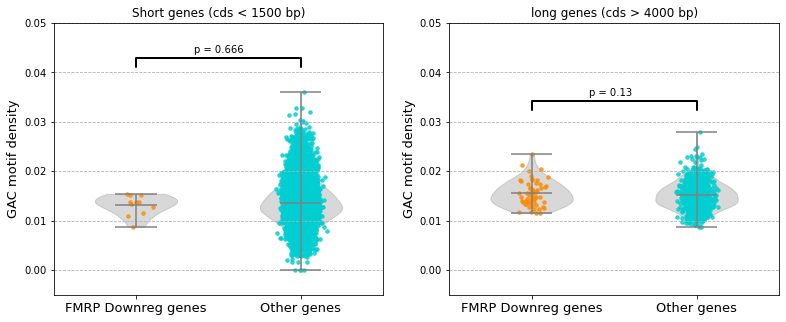

In [131]:
# Creating axes objects
fig, ax = plt.subplots(1,2, figsize = (13,5))

# Adding violin plots
violin_parts = ax[0].violinplot([short_downreg.density_all, short_other.density_all], showmeans = True)

for pc in violin_parts["bodies"]:
    pc.set_facecolor("grey")
    pc.set_edgecolor("grey")
    
for partname in ("cbars","cmins","cmaxes","cmeans"):
    vp = violin_parts[partname]
    vp.set_edgecolor("grey")
    
violin_parts = ax[1].violinplot([long_downreg.density_all, long_other.density_all], showmeans = True)

for pc in violin_parts["bodies"]:
    pc.set_facecolor("grey")
    pc.set_edgecolor("grey")
    
for partname in ("cbars","cmins","cmaxes","cmeans"):
    vp = violin_parts[partname]
    vp.set_edgecolor("grey")
    
# Adding dotplots
x = np.random.normal(1, 0.04, size=len(short_downreg.density_all))
ax[0].scatter(x, short_downreg.density_all, s = 12, color = "darkorange", alpha=0.8)
x = np.random.normal(2, 0.04, size=len(short_other.density_all))
ax[0].scatter(x, short_other.density_all, s = 12,  color = "darkturquoise", alpha=0.8)

x = np.random.normal(1, 0.04, size=len(long_downreg.density_all))
ax[1].scatter(x, long_downreg.density_all, s = 12, color = "darkorange", alpha=0.8)
x = np.random.normal(2, 0.04, size=len(long_other.density_all))
ax[1].scatter(x, long_other.density_all, s = 12,  color = "darkturquoise", alpha=0.8)

# Determining x and y axis limits
ax[0].set_xlim(0.5,2.5)
ax[0].set_ylim(-0.005,0.05)
ax[1].set_xlim(0.5,2.5)
ax[1].set_ylim(-0.005,0.05)

# Labelling the axes.
positions = (1,2)
labels = ("FMRP Downreg genes", "Other genes")
ax[0].set_xticks(positions, labels, fontsize = 13)
ax[1].set_xticks(positions, labels, fontsize = 13)
ax[0].set_ylabel(motif_name + " motif density", fontsize = 13)
ax[1].set_ylabel(motif_name + " motif density", fontsize = 13)

# Giving plot titles.
ax[0].set_title("Short genes (cds < 1500 bp)")
ax[1].set_title("long genes (cds > 4000 bp)")

# Creating grid lines
ax[0].yaxis.grid(linestyle = "--")
ax[1].yaxis.grid(linestyle = "--")

# Add P values
label_diff(0,1,"p = " + str(p_short), [1,2], [0.0001,0.030], ax[0], 0.011)
label_diff(0,1,"p = " + str(p_long), [1,2], [0.0001,0.022], ax[1], 0.011)

# Save the figure
fig.savefig(figure_path + "mouse_" + motif_name + "_frequency.pdf")

In [132]:
means = [(short_downreg.density_all).mean(axis=0),
(short_other.density_all).mean(axis=0),
(long_downreg.density_all).mean(axis=0),
(long_other.density_all).mean(axis=0)]
samples = ["Mouse Downregulated Short", "Mouse Non-downregulated Short", "Mouse Downregulated Long", "Mouse Non-downregulated Long"]

# Get the fraction of non-downregulated genes above the mean count of the downregulated genes. 
short_frac = len(short_other.query("density_all > " + str(means[0])).density_all)/len(short_other.density_all)
long_frac = len(long_other.query("density_all > " + str(means[2])).density_all)/len(long_other.density_all)

frac = [np.nan, short_frac, np.nan, long_frac]

df = pd.DataFrame(zip(samples,means,frac), columns = ["Sample", "Mean " + motif_name + " Frequency", "Fraction of Non-downregulated above mean"])
df.to_csv(table_path + motif_name + "_mouse_data")

## Step 11
Create a set of violin plots that show the distribution of total FMRP binding sites and CDS length for autism and non-autism genes

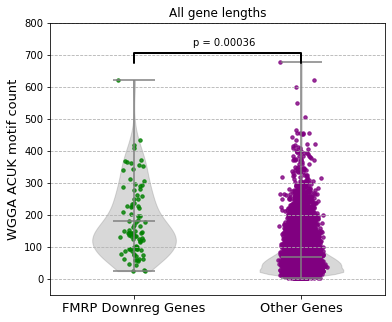

In [54]:
# Creating axes objects
fig, ax = plt.subplots(1,1, figsize = (6,5))

# Adding violin plots
violin_parts = ax.violinplot([downreg_genes.total_all, non_downreg_genes.total_all], showmeans = True)

for pc in violin_parts["bodies"]:
    pc.set_facecolor("grey")
    pc.set_edgecolor("grey")
    
for partname in ("cbars","cmins","cmaxes","cmeans"):
    vp = violin_parts[partname]
    vp.set_edgecolor("grey")
    
# Adding dotplots
x = np.random.normal(1, 0.04, size=len(downreg_genes.total_all))
ax.scatter(x, downreg_genes.total_all, s = 12, color = "green", alpha=0.8)
x = np.random.normal(2, 0.04, size=len(non_downreg_genes.total_all))
ax.scatter(x, non_downreg_genes.total_all, s = 12,  color = "purple", alpha=0.8)

# Determining x and y axis limits
ax.set_xlim(0.5,2.5)
ax.set_ylim(-50,800)

# Labelling the axes.
positions = (1,2)
labels = ("FMRP Downreg Genes", "Other Genes")
ax.set_xticks(positions, labels, fontsize = 13)
ax.set_ylabel("WGGA ACUK motif count", fontsize = 13)

# Giving plot titles.
ax.set_title("All gene lengths")

# Creating grid lines
ax.yaxis.grid(linestyle = "--")
    
# Add P values
label_diff(0,1,"p = 0.00036", [1,2], [0.02,500], ax, 180)

# Save the figure
fig.savefig(save_path + "mouse_total_motifs.pdf")

In [55]:
# Use the permutation test to determine ifthe total FMRP binding sites and length
# Are significantly different between all other genes. 
test = stats.ttest_ind(downreg_genes.total_all, non_downreg_genes.total_all, equal_var = True,
                nan_policy = "omit", permutations = 3000)
print(test)

Ttest_indResult(statistic=21.09586254846259, pvalue=0.0)


# Conclusions:
from the data I am currently able to observe, I can conclude that although the total number of binding sites is higher in ASD gene populations, this is basically entirely dependent on the fact that the ASD genes are generally longer. When looking at binding site frequency/density, there is essentially no change whatsoever. 

# Duplicate version with random 4-mers.

## Step 5:
Create a dataframe that contains the gene name, gene length, and the counts for the FMRP target mRNA sequences

In [17]:
# Create a dataframe with all of the count data for a couple of random tetramers I came up with.  
temp_counts = utils.tetra_counter(transcripts, genome, tetras = ["GCAA", "GCAC", "AAGG", "AAGC"])

---------------------------------------------------------------------------
RuntimeWarning
invalid value encountered in true_divide
in /home/keeganfl/Desktop/measuring_binding_domains/Tools/utilities.py, line 233:

231     # get the count density for each region.
232     density_cds = np.array(total_cds)/np.array(lengths_cds)
233     density_utr5 = np.array(total_utr5)/np.array(lengths_utr5)
234     density_utr3 = np.array(total_utr3)/np.array(lengths_utr3)
235     density_all = np.array(total_all)/np.array(lengths_all)

---------------------------------------------------------------------------
---------------------------------------------------------------------------
RuntimeWarning
invalid value encountered in true_divide
in /home/keeganfl/Desktop/measuring_binding_domains/Tools/utilities.py, line 234:

232     density_cds = np.array(total_cds)/np.array(lengths_cds)
233     density_utr5 = np.array(total_utr5)/np.array(lengths_utr5)
234     density_utr3 = np.array(total_utr3)/np.arra

## Step 6:
Load up the list of APRIS genes. This list will include the transcript IDs of all of the primary isoforms, and will be used to select a single transcript for all genes.

In [18]:
# Load up the Apris genes. 
prin_trans = pd.read_csv(asd_genes_path + "apris_mouse_data.txt", names = ["gene_name", "???", "gene_id", "rank"])

# Remove the extra decimal point from the gene ids so that the gene IDs are the same. 
gene_ids = [] 
for i in prin_trans.gene_id:
    gene_ids.append(i.split('.',1)[0])
prin_trans.gene_id = gene_ids

In [19]:
# Merge the count table with the table of ASD gene names and include an indicator column.
random_counts = pd.merge(temp_counts, prin_trans, how="left", on = "gene_id", indicator = True)

# Only keep counts with a transcript ID that matched one of the APRIS primary IDs.
random_counts = random_counts.loc[random_counts._merge == "both"].copy()

# Drop any duplicate genes (duplicates may remain if multiple transcripts have identical cds regions).
random_counts.drop_duplicates(subset ="gene_name_x",keep = "first", inplace = True) 

# Remove unnecesary columns. 
random_counts.drop(columns = ["gene_name_y", "???", "rank", "_merge"], inplace = True)

## Step 7:
Load up a list containing all of the autism spectrum genes

In [20]:
asd_gene_names = pd.read_csv(asd_genes_path + "asd_genes_mouse.csv", names = ["gene_name", "gene_score", "syndromatic"])

## Step 8:
merge the asd_gene_names and the mouse counts together based on the shared gene names

In [21]:
# merge the count dataframe with the list of asd genes.
temp_df = pd.merge(random_counts, asd_gene_names, how="left", right_on="gene_name", left_on="gene_name_x", indicator = True)

# reset the indices.
temp_df = temp_df.reset_index(drop=True)

# remove titin since its incredible length is annoying for the analysis.
temp_df = temp_df.drop(temp_df[temp_df.lengths_all > 60000].index)

## Step 9:
split the merged table into asd_genes and non_asd_genes tables

In [22]:
# split it into asd_genes and non_asd_genes tables.
asd_genes_rando = temp_df.loc[temp_df._merge == "both"].copy()

non_asd_genes_rando = temp_df.loc[temp_df._merge == "left_only"].copy()

# drop the unecessary columns and sort by gene score. 
non_asd_genes_rando.drop(columns = ["gene_score", "syndromatic", "_merge"], inplace = True)
asd_genes_rando.sort_values(["syndromatic", "gene_score"], ascending = [False, True], inplace = True)

# Reset the indices.
asd_genes_rando = asd_genes_rando.reset_index(drop=True)
non_asd_genes_rando = non_asd_genes_rando.reset_index(drop=True)

# convert gene score to numeric. 
asd_genes_rando.gene_score = pd.to_numeric(asd_genes_rando.gene_score)

## Step 9:
Filter the ASD genes to only look at class 1 and class 2 genes. 

In [23]:
asd_genes_rando = asd_genes_rando.query("gene_score <= 2 | syndromatic == '1'")

### Histograms

In [24]:
short_asd = asd_genes_rando.query("lengths_cds < 1500")
short_other = non_asd_genes_rando.query("lengths_cds < 1500")

long_asd = asd_genes_rando.query("lengths_cds > 4000")
long_other = non_asd_genes_rando.query("lengths_cds > 4000 & lengths_all < 60000")

In [25]:
print(np.mean(short_asd.density_all))
print(np.mean(short_other.density_all))

0.01598079165304956
0.016628233295683876


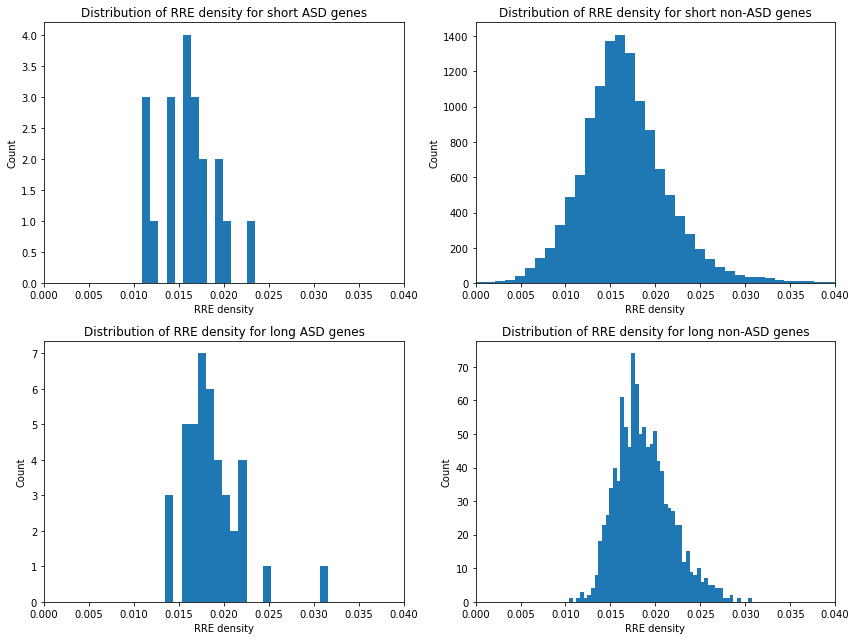

In [26]:
fig, ax = plt.subplots(2,2, figsize = (12,9))
ax[0][0].hist(short_asd.density_all, bins = 14)
ax[0][0].set_xlim((0,0.04))
ax[0][0].set_ylabel("Count")
ax[0][0].set_xlabel("RRE density")
ax[0][0].set_title("Distribution of RRE density for short ASD genes")

ax[0][1].hist(short_other.density_all, bins = 50)
ax[0][1].set_xlim((0,0.04))
ax[0][1].set_ylabel("Count")
ax[0][1].set_xlabel("RRE density")
ax[0][1].set_title("Distribution of RRE density for short non-ASD genes")

ax[1][0].hist(long_asd.density_all, bins = 20)
ax[1][0].set_xlim((0,0.04))
ax[1][0].set_ylabel("Count")
ax[1][0].set_xlabel("RRE density")
ax[1][0].set_title("Distribution of RRE density for long ASD genes")

ax[1][1].hist(long_other.density_all, bins = 50)
ax[1][1].set_xlim((0,0.04))
ax[1][1].set_ylabel("Count")
ax[1][1].set_xlabel("RRE density")
ax[1][1].set_title("Distribution of RRE density for long non-ASD genes")
plt.tight_layout()

Text(0.5, 1.0, 'Distribution of total RREs for non-ASD genes')

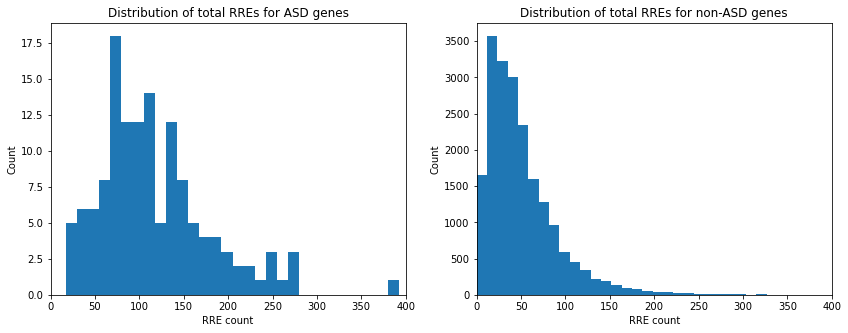

In [27]:
fig, ax = plt.subplots(1,2, figsize = (14,5))
ax[0].hist(asd_genes_rando.total_all, bins = 30)
ax[0].set_xlim((0,400))
ax[0].set_ylabel("Count")
ax[0].set_xlabel("RRE count")
ax[0].set_title("Distribution of total RREs for ASD genes")

ax[1].hist(non_asd_genes_rando.total_all, bins = 50)
ax[1].set_xlim((0,400))
ax[1].set_ylabel("Count")
ax[1].set_xlabel("RRE count")
ax[1].set_title("Distribution of total RREs for non-ASD genes")

Text(0.5, 1.0, 'Distribution of lengths for non-ASD genes')

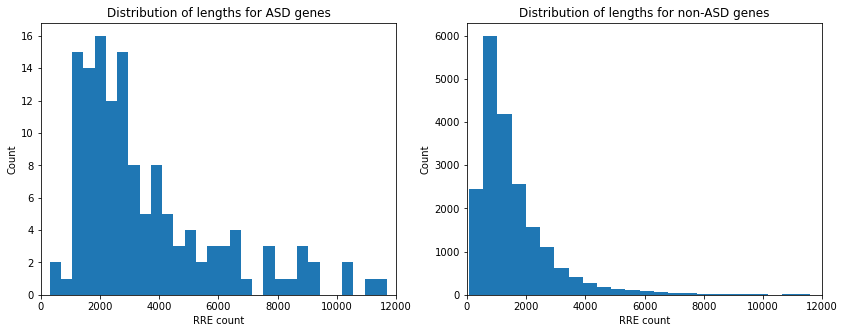

In [28]:
fig, ax = plt.subplots(1,2, figsize = (14,5))
ax[0].hist(asd_genes_rando.lengths_cds, bins = 30)
ax[0].set_xlim((0,12000))
ax[0].set_ylabel("Count")
ax[0].set_xlabel("RRE count")
ax[0].set_title("Distribution of lengths for ASD genes")

ax[1].hist(non_asd_genes_rando.lengths_cds, bins = 50)
ax[1].set_xlim((0,12000))
ax[1].set_ylabel("Count")
ax[1].set_xlabel("RRE count")
ax[1].set_title("Distribution of lengths for non-ASD genes")

### Violin plots

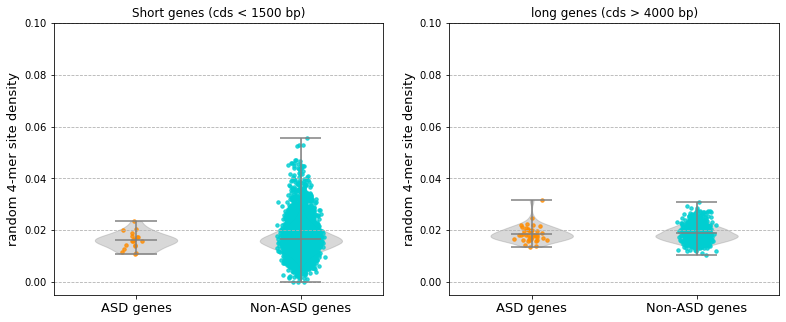

In [29]:
# Creating axes objects
fig, ax = plt.subplots(1,2, figsize = (13,5))

# Adding violin plots
violin_parts = ax[0].violinplot([short_asd.density_all, short_other.density_all], showmeans = True)

for pc in violin_parts["bodies"]:
    pc.set_facecolor("grey")
    pc.set_edgecolor("grey")
    
for partname in ("cbars","cmins","cmaxes","cmeans"):
    vp = violin_parts[partname]
    vp.set_edgecolor("grey")
    
violin_parts = ax[1].violinplot([long_asd.density_all, long_other.density_all], showmeans = True)

for pc in violin_parts["bodies"]:
    pc.set_facecolor("grey")
    pc.set_edgecolor("grey")
    
for partname in ("cbars","cmins","cmaxes","cmeans"):
    vp = violin_parts[partname]
    vp.set_edgecolor("grey")
    
# Adding dotplots
x = np.random.normal(1, 0.04, size=len(short_asd.density_all))
ax[0].scatter(x, short_asd.density_all, s = 12, color = "darkorange", alpha=0.8)
x = np.random.normal(2, 0.04, size=len(short_other.density_all))
ax[0].scatter(x, short_other.density_all, s = 12,  color = "darkturquoise", alpha=0.8)

x = np.random.normal(1, 0.04, size=len(long_asd.density_all))
ax[1].scatter(x, long_asd.density_all, s = 12, color = "darkorange", alpha=0.8)
x = np.random.normal(2, 0.04, size=len(long_other.density_all))
ax[1].scatter(x, long_other.density_all, s = 12,  color = "darkturquoise", alpha=0.8)

# Determining x and y axis limits
ax[0].set_xlim(0.5,2.5)
ax[0].set_ylim(-0.005,0.1)
ax[1].set_xlim(0.5,2.5)
ax[1].set_ylim(-0.005,0.1)

# Labelling the axes.
positions = (1,2)
labels = ("ASD genes", "Non-ASD genes")
ax[0].set_xticks(positions, labels, fontsize = 13)
ax[1].set_xticks(positions, labels, fontsize = 13)
ax[0].set_ylabel("random 4-mer site density", fontsize = 13)
ax[1].set_ylabel("random 4-mer site density", fontsize = 13)

# Giving plot titles.
ax[0].set_title("Short genes (cds < 1500 bp)")
ax[1].set_title("long genes (cds > 4000 bp)")

# Creating grid lines
ax[0].yaxis.grid(linestyle = "--")
ax[1].yaxis.grid(linestyle = "--")

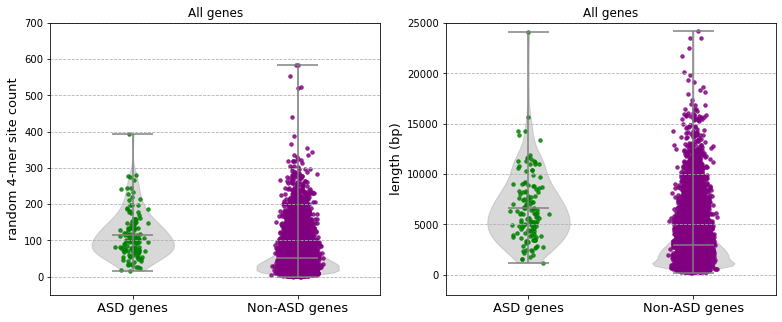

In [30]:
# Creating axes objects
fig, ax = plt.subplots(1,2, figsize = (13,5))

# Adding violin plots
violin_parts = ax[0].violinplot([asd_genes_rando.total_all, non_asd_genes_rando.total_all], showmeans = True)

for pc in violin_parts["bodies"]:
    pc.set_facecolor("grey")
    pc.set_edgecolor("grey")
    
for partname in ("cbars","cmins","cmaxes","cmeans"):
    vp = violin_parts[partname]
    vp.set_edgecolor("grey")
    
violin_parts = ax[1].violinplot([asd_genes_rando.lengths_all, non_asd_genes_rando.lengths_all], showmeans = True)

for pc in violin_parts["bodies"]:
    pc.set_facecolor("grey")
    pc.set_edgecolor("grey")
    
for partname in ("cbars","cmins","cmaxes","cmeans"):
    vp = violin_parts[partname]
    vp.set_edgecolor("grey")
    
# Adding dotplots
x = np.random.normal(1, 0.04, size=len(asd_genes_rando.total_all))
ax[0].scatter(x, asd_genes_rando.total_all, s = 12, color = "green", alpha=0.8)
x = np.random.normal(2, 0.04, size=len(non_asd_genes_rando.total_all))
ax[0].scatter(x, non_asd_genes_rando.total_all, s = 12,  color = "purple", alpha=0.8)

x = np.random.normal(1, 0.04, size=len(asd_genes_rando.lengths_all))
ax[1].scatter(x, asd_genes_rando.lengths_all, s = 12, color = "green", alpha=0.8)
x = np.random.normal(2, 0.04, size=len(non_asd_genes_rando.lengths_all))
ax[1].scatter(x, non_asd_genes_rando.lengths_all, s = 12,  color = "purple", alpha=0.8)

# Determining x and y axis limits
ax[0].set_xlim(0.5,2.5)
ax[0].set_ylim(-50,700)
ax[1].set_xlim(0.5,2.5)
ax[1].set_ylim(-2000,25000)

# Labelling the axes.
positions = (1,2)
labels = ("ASD genes", "Non-ASD genes")
ax[0].set_xticks(positions, labels, fontsize = 13)
ax[1].set_xticks(positions, labels, fontsize = 13)
ax[0].set_ylabel("random 4-mer site count", fontsize = 13)
ax[1].set_ylabel("length (bp)", fontsize = 13)

# Giving plot titles.
ax[0].set_title("All genes")
ax[1].set_title("All genes")

# Creating grid lines
ax[0].yaxis.grid(linestyle = "--")
ax[1].yaxis.grid(linestyle = "--")

# Comparison of RRE and rando

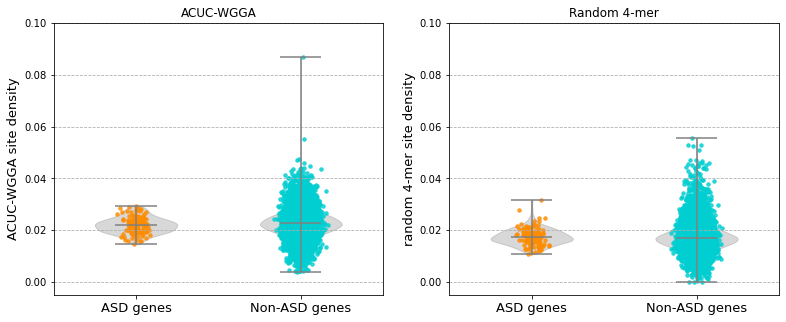

In [31]:
# Creating axes objects
fig, ax = plt.subplots(1,2, figsize = (13,5))

# Adding violin plots
violin_parts = ax[0].violinplot([asd_genes.density_all, non_asd_genes.density_all], showmeans = True)

for pc in violin_parts["bodies"]:
    pc.set_facecolor("grey")
    pc.set_edgecolor("grey")
    
for partname in ("cbars","cmins","cmaxes","cmeans"):
    vp = violin_parts[partname]
    vp.set_edgecolor("grey")
    
violin_parts = ax[1].violinplot([asd_genes_rando.density_all, non_asd_genes_rando.density_all], showmeans = True)

for pc in violin_parts["bodies"]:
    pc.set_facecolor("grey")
    pc.set_edgecolor("grey")
    
for partname in ("cbars","cmins","cmaxes","cmeans"):
    vp = violin_parts[partname]
    vp.set_edgecolor("grey")
    
# Adding dotplots
x = np.random.normal(1, 0.04, size=len(asd_genes.density_all))
ax[0].scatter(x, asd_genes.density_all, s = 12, color = "darkorange", alpha=0.8)
x = np.random.normal(2, 0.04, size=len(non_asd_genes.density_all))
ax[0].scatter(x, non_asd_genes.density_all, s = 12,  color = "darkturquoise", alpha=0.8)

x = np.random.normal(1, 0.04, size=len(asd_genes_rando.density_all))
ax[1].scatter(x, asd_genes_rando.density_all, s = 12, color = "darkorange", alpha=0.8)
x = np.random.normal(2, 0.04, size=len(non_asd_genes_rando.density_all))
ax[1].scatter(x, non_asd_genes_rando.density_all, s = 12,  color = "darkturquoise", alpha=0.8)

# Determining x and y axis limits
ax[0].set_xlim(0.5,2.5)
ax[0].set_ylim(-0.005,0.1)
ax[1].set_xlim(0.5,2.5)
ax[1].set_ylim(-0.005,0.1)

# Labelling the axes.
positions = (1,2)
labels = ("ASD genes", "Non-ASD genes")
ax[0].set_xticks(positions, labels, fontsize = 13)
ax[1].set_xticks(positions, labels, fontsize = 13)
ax[0].set_ylabel("ACUC-WGGA site density", fontsize = 13)
ax[1].set_ylabel("random 4-mer site density", fontsize = 13)

# Giving plot titles.
ax[0].set_title("ACUC-WGGA")
ax[1].set_title("Random 4-mer")

# Creating grid lines
ax[0].yaxis.grid(linestyle = "--")
ax[1].yaxis.grid(linestyle = "--")